In [1]:
# ! pip install tabula-py
# !java -version
#### ###

In [2]:
import tabula
from IPython.display import display
import pandas as pd 
# import re
import numpy as np
import pickle
# import time

from selenium import webdriver 
from selenium.webdriver.common.by import By 
# from selenium.webdriver.support.ui import WebDriverWait 
# from selenium.webdriver.support import expected_conditions as EC 
# from selenium.common.exceptions import TimeoutException

# Scrape av PDF

In [3]:
def get_pdf_files(driver):
    a = driver.find_elements_by_partial_link_text("Vaxzevria - Svenska")[0]
    url_astra = a.get_attribute('href')

    p = driver.find_elements_by_partial_link_text("Comirnaty - Svenska")[0]
    url_pfizer = p.get_attribute('href')
    
    m = driver.find_elements_by_partial_link_text("Spikevax - Svenska")[0]
    url_moderna = m.get_attribute('href')

    pdf_astra   = tabula.read_pdf(url_astra  , pages = "all", multiple_tables = True, user_agent='Mozilla/5.0') 
    pdf_pfizer  = tabula.read_pdf(url_pfizer , pages = "all", multiple_tables = True, user_agent='Mozilla/5.0') 
    pdf_moderna = tabula.read_pdf(url_moderna, pages = "all", multiple_tables = True, user_agent='Mozilla/5.0') 
    return pdf_astra, pdf_pfizer, pdf_moderna   
# a = driver.find_elements_by_partial_link_text("Spikevax - Svenska")[0]
# url_moderna = a.get_attribute('href')
# pdf_moderna = tabula.read_pdf(url_moderna , pages = "all", multiple_tables = True, user_agent='Mozilla/5.0') 


In [4]:
# pdf_pfizer[5]

In [5]:
def find_ix_in_pdf(pdf, word):
    # print(range(0,len(pdf)))
    for i in range(0, len(pdf)):
        # print(i)
        tab = list(pdf[i].columns)
        tab = [x.replace('\r', ' ') for x in tab]
        tab_str = ''.join(tab)
        if word in tab_str:
            print('Found word', word, 'in pdf', i)
            return pdf[i], i

    return 'Error', -1000

def antal_döda(pdf_astra,pdf_pfizer,pdf_moderna):
       print('pdf_astra', end=': ')
       _, ixa = find_ix_in_pdf(pdf_astra, 'Dödsfall')
       print('pdf_pfizer', end=': ')
       _, ixp = find_ix_in_pdf(pdf_pfizer, 'Dödsfall')
       print('pdf_moderna', end=': ')
       _, ixm = find_ix_in_pdf(pdf_moderna, 'Dödsfall')
          
       a = ['Astra'] + pdf_astra[ixa].loc[:,'Totalt'].astype(int).to_list()
       try:
              m = ['Moderna'] + pdf_moderna[ixm].loc[:,'Totalt'].str.replace(',','').astype(int).to_list()
       except:
              m = ['Moderna'] + pdf_moderna[ixm].loc[:,'Totalt'].astype(int).to_list()       
              
       pdf_pfizer[ixp].columns = ['Dödsfall', '10-19', '20-29', '30-39', '40-49',
              '50-59', '60-69', '70-79', '80-89', '90+',
              'okänt', 'Totalt']
       p = ['Pfizer'] + pdf_pfizer[ixp].loc[:,'Totalt'].astype(int).to_list()
       p = p[:-2]+[p[-1]] # ta bort okänt (kön)

       df =pd.DataFrame([p,m,a], columns=['Antal_döda','Kvinnor','Män','Totalt'])
       df.loc[-1]=['Totaler']+df[['Kvinnor','Män','Totalt']].sum().to_list()
       
       df = df.set_index('Antal_döda')
        
       return df
# antal_döda(pdf_astra,pdf_pfizer,pdf_moderna)


In [6]:

def antal_allvarliga(pdf_astra,pdf_pfizer,pdf_moderna):
       print('pdf_astra', end=': ')
       _,ixa = find_ix_in_pdf(pdf_astra, 'allvarlig')
       print('pdf_pfizer', end=': ')
       _,ixp = find_ix_in_pdf(pdf_pfizer, 'allvarlig')
       print('pdf_moderna', end=': ')
       _,ixm = find_ix_in_pdf(pdf_moderna, 'allvarlig')
       kolumner = ['Ej allvarliga', 'Allvarliga']
       astra = pdf_astra[ixa].drop('Totalt',axis=1).copy()
       
       astra.columns=['Astra'] + kolumner
       astra['Ej allvarliga'] = astra['Ej allvarliga'].str.replace(',','').astype(int)
       astra['Allvarliga'] = astra['Allvarliga'].str.replace(',','').astype(int)
       astra['Totalt'] = astra['Ej allvarliga'] + astra.Allvarliga
       
       moderna = pdf_moderna[ixm].drop('Totalt',axis=1).copy()
       # print(moderna)
       moderna.columns=['Moderna'] + kolumner
       moderna['Allvarliga'] = moderna['Allvarliga'].str.replace(',','').astype(int)
       moderna['Ej allvarliga'] = moderna['Ej allvarliga'].str.replace(',', '').astype(int)
       moderna['Totalt'] = moderna['Ej allvarliga'] + moderna.Allvarliga
       # print(moderna)
       pfizer = pdf_pfizer[ixp].drop('Totalt',axis=1).copy()
       pfizer.columns=['Pfizer'] + kolumner
       pfizer['Ej allvarliga'] = pfizer['Ej allvarliga'].str.replace(',','').astype(int)
       pfizer['Allvarliga']    = pfizer['Allvarliga'].str.replace(',','').astype(int)
       pfizer['Totalt']       = pfizer['Ej allvarliga'] + pfizer.Allvarliga
      
       # moderna['Totalt']+astra['Totalt']+pfizer['Totalt']
       # print('SVAR',moderna)
       return (astra,pfizer,moderna)

# antal_allvarliga(pdf_astra,pdf_pfizer,pdf_moderna)


In [7]:
# pdf_astra[2].columns

# Scrape av sidan

In [8]:
# create driver and start url
url='https://www.lakemedelsverket.se/sv/coronavirus/coronavaccin/inrapporterade-misstankta-biverkningar---coronavacciner'
driver = webdriver.Chrome(executable_path='C:\\Users\peter\\Documents\\MyProjects\\gecko\\chromedriver.exe')
driver.get(url)              # öppna startlista
driver.implicitly_wait(5)     # seconds

C:\Users\peter\AppData\Local\Temp/ipykernel_5740/3386962049.py:3: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver = webdriver.Chrome(executable_path='C:\\Users\peter\\Documents\\MyProjects\\gecko\\chromedriver.exe')


In [9]:
datconv={'Januari':'January', 'Februari':'February', 'Mars':'March', 'April':'April', 'Maj':'May', 'Juni':'June', 'Juli':'July', 'Augusti':'August', 'September':'September', 'Oktober':'October', 'November':'November', 'December':'December',
         'januari':'january', 'februari':'february', 'mars':'march', 'april':'april', 'maj':'may', 'juni':'june', 'juli':'july', 'augusti':'august', 'september':'september', 'oktober':'october', 'november':'november', 'december':'december'}
def get_date_of_report(driver):
    datum = driver.find_element(By.XPATH, '//*[@id="content"]/div/ng-component/div/div[2]/ul/li[2]/span[2]').text
    # replace month in datum    
    for k,v in datconv.items():
        datum = datum.replace(k,v)
    return pd.to_datetime(datum).strftime('%Y-%m-%d')


# d=get_date_of_report(driver)
# # week number of d
# week = pd.to_datetime(d).week
# print(d)
# print(week)

In [10]:

def get_antal_okända(driver):
    # löpande_text = driver.find_elements_by_xpath('//*[@id="content"]/div/ng-component/div/div[2]/xhtmlstring[2]/div/p[5]')[0].text
    #löpande_text = driver.find_elements(By.XPATH,'//*[@id="content"]/div/ng-component/div/div[2]/xhtmlstring[2]/div/p[6]')[0].text
    löpande_text = driver.find_elements(By.XPATH, '//*[@id="content"]/div/ng-component/div/div[2]/xhtmlstring[2]/div/p[7]')[0].text
    # print(löpande_text)
    sök_på = 'det även kommit in '
    startix = löpande_text.find(sök_på) + len(sök_på)  # här startar det numeriska värdet
    numlen= löpande_text[startix:].find(' ')
    
    antal_okända = löpande_text[startix:startix+numlen]
    print('antal okända',antal_okända)
    return int(antal_okända)
antal_okänd_spruta = get_antal_okända(driver)


antal okända 432


In [11]:
#  tabellen med antal doser och inkommna rapporter
def get_inkomna_rapporter(driver):    
    # inkomna = driver.find_element_by_class_name('tinyMceTable')
    pfizer_inkomna = driver.find_elements(By.XPATH,'//*[@id = "content"]/div/ng-component/div/div[2]/xhtmlstring[2]/div/div[3]/p[2]/span')[0].text
    pfizer_inkomna = int(pfizer_inkomna.replace(' ', ''))
    
    moderna_inkomna = driver.find_elements(By.XPATH, 
    '//*[@id="content"]/div/ng-component/div/div[2]/xhtmlstring[2]/div/div[3]/p[7]/span')[0].text
    moderna_inkomna = int(moderna_inkomna.replace(' ', ''))
    
    astra_inkomna = driver.find_elements(By.XPATH, 
    '//*[@id="content"]/div/ng-component/div/div[2]/xhtmlstring[2]/div/div[3]/p[10]/span')[0].text
    astra_inkomna = int(astra_inkomna.replace(' ', ''))
    
    # elems = inkomna_pf.find_elements_by_tag_name('tr')
    
    # pfizer_inkomna = int(elems[1].find_elements_by_tag_name('td')[2].text.replace(' ',''))
    # moderna_inkomna = int(elems[2].find_elements_by_tag_name('td')[2].text.replace(' ',''))
    # astra_inkomna = int(elems[3].find_elements_by_tag_name('td')[2].text.replace(' ',''))
    
    return pfizer_inkomna, moderna_inkomna, astra_inkomna

summa_rapporter = sum(get_inkomna_rapporter(driver))+antal_okänd_spruta
with open('pickle/summa_rapporter.pkl','wb') as f:
    pickle.dump(summa_rapporter, f)
    
print('summa_rapporter:',summa_rapporter)  
print(f"\nOBS\nKOLLA ATT DET ÄR 433 == {antal_okänd_spruta} RAPPORTER AV OKÄND SPRUTA\nOBS\n")   
print('Dump antal okänd spruta =',antal_okänd_spruta)
with open('pickle/okänd_spruta.pkl','wb') as f:
    pickle.dump(antal_okänd_spruta, f)


summa_rapporter: 102186

OBS
KOLLA ATT DET ÄR 433 == 432 RAPPORTER AV OKÄND SPRUTA
OBS

Dump antal okänd spruta = 432


In [12]:

def get_antal_doser(driver):
    #  tabellen med antal doser och inkommna rapporter
    # doser = driver.find_element_by_class_name('tinyMceTable')
    # elems = doser.find_elements_by_tag_name('tr')
    pfizer_doser = driver.find_elements(By.XPATH, '//*[@id="content"]/div/ng-component/div/div[2]/xhtmlstring[2]/div/div[3]/p[1]/span')[0].text
    pfizer_doser = int(pfizer_doser.replace(' ', ''))
    print('pfizer_doser',pfizer_doser)
    
    moderna_doser = driver.find_elements(By.XPATH, '//*[@id="content"]/div/ng-component/div/div[2]/xhtmlstring[2]/div/div[3]/p[4]/span')[0].text
    moderna_doser = int(moderna_doser.replace(' ', ''))
    print('moderna_doser',moderna_doser)
    
    astra_doser = driver.find_elements(By.XPATH, '//*[@id="content"]/div/ng-component/div/div[2]/xhtmlstring[2]/div/div[3]/p[7]/span')[0].text
    astra_doser = int(astra_doser.replace(' ', ''))
    print('astra_doser',astra_doser)
    return pfizer_doser,moderna_doser,astra_doser
get_antal_doser(driver)


pfizer_doser 16184232
moderna_doser 1166
astra_doser 22725


(16184232, 1166, 22725)

# Get pdf-filer 
#### men först antal inkomna rapporter, antal doser, antal veckor

In [13]:
datum = get_date_of_report(driver)
week = pd.to_datetime(datum).week
antal_veckor = 52-9 + week

pfizer_inkomna, moderna_inkomna, astra_inkomna = get_inkomna_rapporter(driver)
summa_rapporter # inkluderar rapporter av okänd spruta

# print('antal rapporter',summa_rapporter, 'snitt per vecka',int(summa_rapporter/antal_veckor)) 
Antal_Rapporter = pd.DataFrame([[summa_rapporter,int(summa_rapporter/antal_veckor)]],columns=['inrapporterat','veckosnitt'])
display(Antal_Rapporter)

pfizer_doser,moderna_doser,astra_doser = get_antal_doser(driver)
antal_doser = pfizer_doser + moderna_doser + astra_doser
print('Antal doser. Pfizer,Moderna,Astra:',pfizer_doser,moderna_doser,astra_doser)
print('Antal inkomna rapporter i relation till antl doser. Pf,Mo,As',end=': ')
for p in [pfizer_inkomna/pfizer_doser,  moderna_inkomna/moderna_doser,  astra_inkomna/astra_doser]:
    print(round(p*100,2),end=' ')

# Antal_Rapporter.to_excel('Rapporterat.xlsx',index=False)
pdf_astra, pdf_pfizer, pdf_moderna = get_pdf_files(driver)

,inrapporterat,veckosnitt
0,102186,1792


pfizer_doser 16184232
moderna_doser 1166
astra_doser 22725
Antal doser. Pfizer,Moderna,Astra: 16184232 1166 22725
Antal inkomna rapporter i relation till antl doser. Pf,Mo,As: 0.34 1948.97 108.91 

C:\Users\peter\AppData\Local\Temp/ipykernel_5740/3408932834.py:2: DeprecationWarning: find_elements_by_* commands are deprecated. Please use find_elements() instead
  a = driver.find_elements_by_partial_link_text("Vaxzevria - Svenska")[0]
C:\Users\peter\AppData\Local\Temp/ipykernel_5740/3408932834.py:5: DeprecationWarning: find_elements_by_* commands are deprecated. Please use find_elements() instead
  p = driver.find_elements_by_partial_link_text("Comirnaty - Svenska")[0]
C:\Users\peter\AppData\Local\Temp/ipykernel_5740/3408932834.py:8: DeprecationWarning: find_elements_by_* commands are deprecated. Please use find_elements() instead
  m = driver.find_elements_by_partial_link_text("Spikevax - Svenska")[0]


In [14]:
display("ANTAL DÖDA")
Antal_Döda = antal_döda(pdf_astra,pdf_pfizer,pdf_moderna)
Antal_Döda['Veckosnitt'] = round(Antal_Döda.Totalt/antal_veckor,1)
display(Antal_Döda)
# Antal_Döda.to_excel('Antal_döda.xlsx')

lista=antal_allvarliga(pdf_astra,pdf_pfizer,pdf_moderna )
display("ANTAL HANDLAGDA")
Astra = pd.DataFrame(lista[0])
Pfizer = pd.DataFrame(lista[1])
Moderna = pd.DataFrame(lista[2])
display(Astra)
display (Pfizer)
display(Moderna)
# Astra.to_excel('Astra_handlagda.xlsx',index=False)
# Pfizer.to_excel('Pfizer_handlagda.xlsx',index=False)
# Moderna.to_excel('Moderna_handlagda.xlsx',index=False)

'ANTAL DÖDA'

pdf_astra: Found word Dödsfall in pdf 5
pdf_pfizer: Found word Dödsfall in pdf 5
pdf_moderna: Found word Dödsfall in pdf 5


,Kvinnor,Män,Totalt,Veckosnitt
Antal_döda,,,,
Pfizer,163,137,301,5.3
Moderna,18,25,43,0.8
Astra,19,28,47,0.8
Totaler,200,190,391,6.9


pdf_astra: Found word allvarlig in pdf 2
pdf_pfizer: Found word allvarlig in pdf 2
pdf_moderna: Found word allvarlig in pdf 2


'ANTAL HANDLAGDA'

,Astra,Ej allvarliga,Allvarliga,Totalt
0,Hälso och Sjukvård,2139,996,3135
1,Konsument,3367,1212,4579
2,Antal rapporter,5506,2208,7714


,Pfizer,Ej allvarliga,Allvarliga,Totalt
0,Hälso och Sjukvård,2612,2795,5407
1,Konsument,5060,3773,8833
2,Antal rapporter,7672,6568,14240


,Moderna,Ej allvarliga,Allvarliga,Totalt
0,Hälso och Sjukvård,573,693,1266
1,Konsument,1588,994,2582
2,Antal rapporter,2161,1687,3848


In [15]:
# pdf_astra

In [16]:
display('TOTALT ASTRA + MODERNA + PFIZER :') 

df_tot = pd.DataFrame(lista[0].iloc[2:,1:]+lista[1].iloc[2:,1:]+lista[2].iloc[2:,1:])
df_tot.set_index('Totalt',inplace=True)

totalt_allvarliga=lista[0].iloc[2:,1:].values[0][1]+lista[1].iloc[2:,1:].values[0][1]+lista[2].iloc[2:,1:].values[0][1]

df_tot['veckosnitt (allvarliga)'] = round(totalt_allvarliga/antal_veckor)
display(df_tot)
with open('pickle/summa_handlagda.pkl','wb') as f:
    pickle.dump(df_tot.index[0], f)

with open('pickle/summa_allvarliga.pkl','wb') as f:
    pickle.dump(df_tot.Allvarliga.values[0], f)

# df_tot.to_excel('Handlagda.xlsx',index=False)


'TOTALT ASTRA + MODERNA + PFIZER :'

,Ej allvarliga,Allvarliga,veckosnitt (allvarliga)
Totalt,,,
25802,15339,10463,184


In [17]:
def skapa_ålderstabell(företag,tab):
    r_ix=1 if företag=='Pfizer' else 0
    if företag in ['Pfizer']:
        kolumner = ['Allvarligt kvinnor','Allvarligt män', 'Allvarligt okänt', 'Ej allvarligt kvinnor','Ej allvarligt män','Ej allvarligt okänt']
        print('kolumner i tab', tab.iloc[r_ix:r_ix+1, 1:].values[0])
    elif företag in ['Astra']:
        kolumner = ['Allvarligt kvinnor','Allvarligt män', 'Ej allvarligt kvinnor','Ej allvarligt män','Ej allvarligt okänt']
        print('kolumner i tab', tab.iloc[r_ix:r_ix+1, 1:].values[0])
    else:    
        kolumner = ['Allvarligt kvinnor','Allvarligt män', 'Ej allvarligt kvinnor','Ej allvarligt män']
        print('kolumner i tab', tab.iloc[r_ix:r_ix+1, 1:].values[0])
    
    print('kolumner', kolumner)
    # display(tab)
    try:  #drop Totalt
        the_tab = tab.drop('Unnamed: 0',axis=1).iloc[:-1].copy()
        print(företag,'droppar Unnamed: 0')
    except:    
        # det finns ingen "Unnamed: 0" dvs Total
        print(företag, 'Unnamed fanns inte ')    
        the_tab=tab.copy()
    
    if (the_tab.Allvarlighetsgrad == '0-9 år').sum()>0:
        print('0-9 finns')
        ix = the_tab.loc[the_tab['Allvarlighetsgrad'] == '0-9 år',:].index[0]
    else:
        print('0-9 finns inte')
        ix = the_tab.loc[the_tab['Allvarlighetsgrad'] == '10-19 år',:].index[0]
    # print('ix',ix,the_tab.iloc[ix:-1,:])
    the_tab = the_tab.iloc[ix:-1,:]

    the_tab.fillna('0',inplace=True)
    
    the_tab.columns=[företag] + kolumner
    for kol in kolumner:
        # remove ','
        the_tab[kol] = the_tab[kol].str.replace(',','')
        the_tab[kol] = the_tab[kol].astype(int)
    return the_tab
    
def tre_ålderstabeller():
    ixa = 3
    ixp = 3
    ixm = 3

    astra = skapa_ålderstabell('Astra',pdf_astra[ixa])
    pfizer = skapa_ålderstabell('Pfizer',pdf_pfizer[ixp])
    moderna = skapa_ålderstabell('Moderna',pdf_moderna[ixm])
    return astra,pfizer,moderna
   
astra, pfizer, moderna = tre_ålderstabeller()   

print('Efter')
display(astra)
display(pfizer)
display(moderna)


kolumner i tab ['Kvinna' 'Man' 'Kvinna' 'Man' 'Okänt' 'Totalt']
kolumner ['Allvarligt kvinnor', 'Allvarligt män', 'Ej allvarligt kvinnor', 'Ej allvarligt män', 'Ej allvarligt okänt']
Astra droppar Unnamed: 0
0-9 finns
kolumner i tab ['Kvinna' 'Man' 'Okänt' 'Kvinna' 'Man' 'Okänt' 'Totalt']
kolumner ['Allvarligt kvinnor', 'Allvarligt män', 'Allvarligt okänt', 'Ej allvarligt kvinnor', 'Ej allvarligt män', 'Ej allvarligt okänt']
Pfizer droppar Unnamed: 0
0-9 finns
kolumner i tab ['Kvinna' 'Man' 'Kvinna' 'Man' 'Totalt']
kolumner ['Allvarligt kvinnor', 'Allvarligt män', 'Ej allvarligt kvinnor', 'Ej allvarligt män']
Moderna droppar Unnamed: 0
0-9 finns inte
Efter


,Astra,Allvarligt kvinnor,Allvarligt män,Ej allvarligt kvinnor,Ej allvarligt män,Ej allvarligt okänt
1,0-9 år,0,0,0,1,0
2,10-19 år,9,2,21,6,0
3,20-29 år,99,22,599,102,0
4,30-39 år,167,33,758,155,0
5,40-49 år,182,34,706,81,0
6,50-59 år,228,42,763,71,1
7,60-69 år,315,185,653,175,1
8,70-79 år,466,334,938,386,1
9,80-89 år,41,36,41,14,0
10,90+,2,4,0,0,0


,Pfizer,Allvarligt kvinnor,Allvarligt män,Allvarligt okänt,Ej allvarligt kvinnor,Ej allvarligt män,Ej allvarligt okänt
3,0-9 år,0,0,0,0,1,0
4,10-19 år,74,109,0,92,32,1
5,20-29 år,305,183,0,725,186,0
6,30-39 år,628,301,0,1283,260,1
7,40-49 år,720,355,0,1288,269,0
8,50-59 år,851,458,0,1373,247,3
9,60-69 år,596,396,0,685,186,1
10,70-79 år,471,319,0,353,165,0
11,80-89 år,340,243,0,228,105,0
12,90+,135,47,0,97,32,0


,Moderna,Allvarligt kvinnor,Allvarligt män,Ej allvarligt kvinnor,Ej allvarligt män
1,10-19 år,29,62,19,11
2,20-29 år,90,86,223,51
3,30-39 år,198,100,376,128
4,40-49 år,206,109,359,125
5,50-59 år,175,138,324,79
6,60-69 år,121,71,148,43
7,70-79 år,105,81,128,39
8,80-89 år,54,27,59,25
9,90+,20,6,10,4


In [18]:
'Totalt antal biverkningar',df_tot.index.values[0]

('Totalt antal biverkningar', 25802)

# Grafer

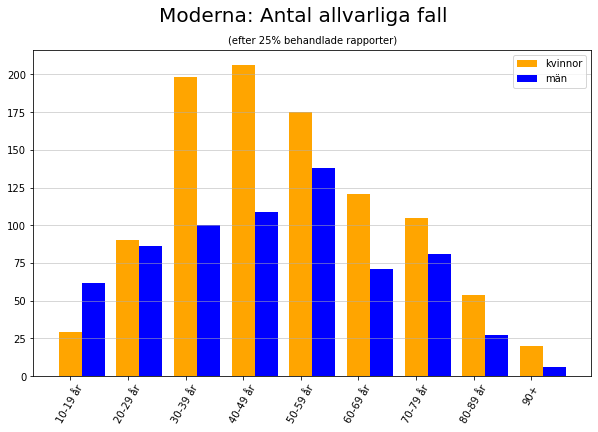

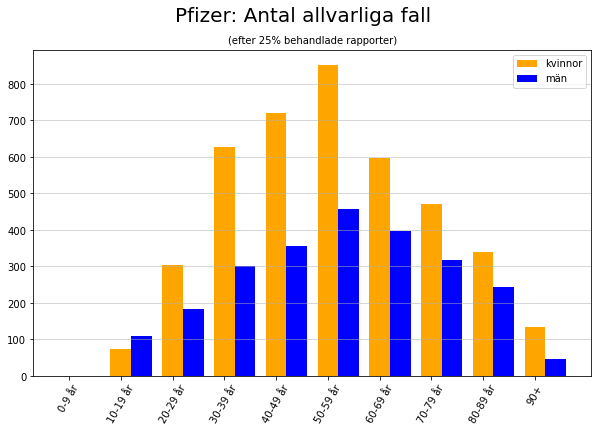

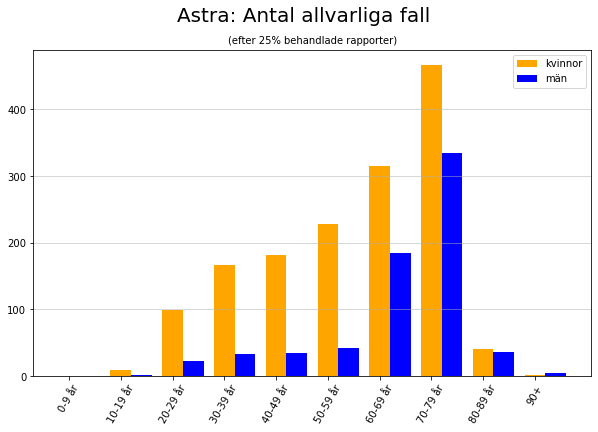

In [19]:
import matplotlib.pyplot as plt
import numpy as np
def plot_inkomna():
    plt.figure(figsize=(10,8))
    plt.plot(df_tot.index,df_tot['Pfizer'],label='Pfizer')
    plt.plot(df_tot.index,df_tot['Moderna'],label='Moderna')
    plt.plot(df_tot.index,df_tot['Astra'],label='Astra')
    plt.legend()
    plt.title('Antal rapporterade fall')
    plt.xlabel('Vecka')
    plt.ylabel('Antal rapporterade fall')
    plt.show()

def plot_allvarliga_per_ålder(åldrar, ftag):
    plt.figure(figsize=(10,6))
    spc = np.arange(len(ftag[åldrar]))
    plt.bar(spc, ftag['Allvarligt kvinnor'], width=0.4,label='kvinnor',color='orange')
    plt.bar(spc+0.4,ftag['Allvarligt män'], width=0.4,label='män',color='b')
    plt.xticks(spc,ftag[åldrar],rotation=60)
    plt.legend()
    andel_behandlade = int(round(df_tot.index.values[0]/summa_rapporter,2)*100)
    plt.title(f'(efter {andel_behandlade}% behandlade rapporter)',fontsize=10)
    plt.suptitle(f'{åldrar}: Antal allvarliga fall',fontsize=20)
    plt.grid(axis='y', linestyle='-', linewidth=0.5)
    nummer = 7 if åldrar == 'Totalt' else 8

    plt.savefig(f'{nummer} {åldrar}_allvarliga_per_åldersgrupp_{datum}_v{week}.jpg')
    plt.show()
plot_allvarliga_per_ålder('Moderna',moderna)
plot_allvarliga_per_ålder('Pfizer', pfizer)
plot_allvarliga_per_ålder('Astra',astra)


Allvarligt kvinnor
[  0  29  90 198 206 175 121 105  54  20]
[  0  74 305 628 720 851 596 471 340 135]
[  0   9  99 167 182 228 315 466  41   2]
[   0  112  494  993 1108 1254 1032 1042  435  157]
Allvarligt män
[  0  62  86 100 109 138  71  81  27   6]
[  0 109 183 301 355 458 396 319 243  47]
[  0   2  22  33  34  42 185 334  36   4]
[  0 173 291 434 498 638 652 734 306  57]
Ej allvarligt kvinnor
[  0  19 223 376 359 324 148 128  59  10]
[   0   92  725 1283 1288 1373  685  353  228   97]
[  0  21 599 758 706 763 653 938  41   0]
[   0  132 1547 2417 2353 2460 1486 1419  328  107]
Ej allvarligt män
[  0  11  51 128 125  79  43  39  25   4]
[  1  32 186 260 269 247 186 165 105  32]
[  1   6 102 155  81  71 175 386  14   0]
[  2  49 339 543 475 397 404 590 144  36]


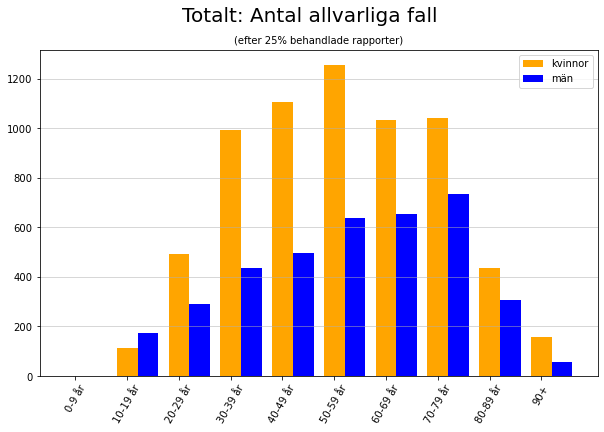

In [20]:
if pfizer.iloc[0,0] != '0-9 år':
    pf=pd.DataFrame([['0-9 år',0,0,0,0,0,0]],columns=pfizer.columns)
    pfizer = pd.concat([pf,pfizer])
    
if moderna.iloc[0,0] != '0-9 år':
    pf=pd.DataFrame([['0-9 år',0,0,0,0]],columns=moderna.columns)
    moderna = pd.concat([pf,moderna])
    
if astra.iloc[0,0] != '0-9 år':
    pf=pd.DataFrame([['0-9 år',0,0,0,0]],columns=astra.columns)
    astra = pd.concat([pf,astra])
       
df_tot_per_ålder = pd.DataFrame(columns=['Totalt','Allvarligt kvinnor','Allvarligt män','Ej allvarligt kvinnor','Ej allvarligt män'])
df_tot_per_ålder['Totalt'] = moderna.Moderna
for kol in df_tot_per_ålder.columns[1:]:
    print(kol)
    print(moderna[kol].values)
    print(pfizer[kol].values)
    print(astra[kol].values)
    df_tot_per_ålder[kol] = moderna[kol].values+pfizer[kol].values+astra[kol].values
    print(df_tot_per_ålder[kol].values)
    
df_tot_per_ålder

plot_allvarliga_per_ålder('Totalt',df_tot_per_ålder)

In [21]:
# astra.to_csv('astra_per_ålder.csv',index=False)
# pfizer.to_csv('pfizer_per_ålder.csv',index=False)
# moderna.to_csv('moderna_per_ålder.csv',index=False)
# df_tot_per_ålder.to_csv('totalt_allvarliga_per_ålder.csv',index=False)

# Kör allt ovan fram till hit

# Tester

In [22]:
(8674+1774+5088)/(45353+17560+24467+359
                  )

0.17707062993651626